In [1]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo
from NaDropper import HighNaNDropper
from sklearn.pipeline import Pipeline
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
colors = ["#9AD0F5", "#A7E8BD", "#C5A3FF", "#FFD8B1"]

In [3]:
def build_pipeline(**args):
    pipeline = Pipeline([
        ('dropper', HighNaNDropper(threshold=0.3)),
        ('imputer', KNNImputer()),
        ('classifier', DecisionTreeClassifier(**args))
    ])
    return pipeline

In [4]:
def build_preprocess_pipeline():
    pipeline = Pipeline([
        ('imputer', KNNImputer()),
    ])
    return pipeline

In [5]:
def process_dataset(x, y, balance=False):
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, shuffle=True)
    y_train = np.ravel(y_train)
    preprocess_pipeline = build_preprocess_pipeline()
    x_train_processed = preprocess_pipeline.fit_transform(x_train)
    if balance:
        x_resampled, y_resampled = SMOTE().fit_resample(x_train_processed, y_train)
        return x_resampled, y_resampled, x_test, y_test
    else:
        return x_train_processed, y_train, x_test, y_test

In [6]:
def get_hyperparams_for_dataset(pipeline, x, y, scoring):
    param_grid = {
    'classifier__ccp_alpha': np.linspace(0, 0.25, 30),
    'classifier__max_depth': [3, 5, 10, 20, None],
    'classifier__min_samples_leaf': [2, 3, 5, 10]
    }
    search = HalvingGridSearchCV(pipeline, param_grid=param_grid, aggressive_elimination=True, n_jobs=2, scoring=scoring, cv=3)
    search.fit(x, y)
    ccp_alpha, max_depth, min_samples = search.best_params_['classifier__ccp_alpha'], search.best_params_['classifier__max_depth'], search.best_params_['classifier__min_samples_leaf']
    return {'ccp_alpha': ccp_alpha, 'max_depth': max_depth, 'min_samples': min_samples}

In [7]:
def build_for_hyperparams(params_dict, weighted):
    ccp = params_dict['ccp_alpha']
    max_depth = params_dict['max_depth']
    min_samples = params_dict['min_samples']
    pipeline = build_pipeline(ccp_alpha=ccp, max_depth=max_depth, min_samples_leaf=min_samples, class_weight='balanced' if weighted else None)

    return pipeline

In [8]:
from sklearn.model_selection import cross_val_score

def get_cv_metrics(pipeline, x, y, stratified=False):
    f1 = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='f1_micro')
    recall = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='recall_micro')
    accuracy = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='accuracy')
    precision = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='precision_micro')

    return pd.DataFrame.from_dict({'f1': f1, 'recall': recall, 'accuracy': accuracy, 'precision': precision})

In [23]:
def get_metrics(pipeline, x_test, y_test):
    y_pred = pipeline.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    return pd.DataFrame.from_dict({'f1': f1, 'recall': recall, 'accuracy': accuracy, 'precision': precision})

In [26]:
def get_metrics(pipeline, x_test, y_test):
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return pd.DataFrame.from_dict({'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1': [f1]})

In [10]:
import os.path
import pickle as pkl

def load_cache_dataset(filename: str, id: int):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            dataset = pkl.load(f)
    else:
        dataset = fetch_ucirepo(id=id)
        with open(filename, 'wb') as f:
            pkl.dump(dataset, f)
    return dataset

polish_companies_bankruptcy = load_cache_dataset('pcb.pkl', 365)
iris = load_cache_dataset('iris.pkl', 53)
iris.data.targets = LabelEncoder().fit_transform(iris.data.targets.to_numpy().reshape(-1,))

In [11]:
x_companies, y_companies, x_companies_test, y_companies_test = process_dataset(polish_companies_bankruptcy.data.features, polish_companies_bankruptcy.data.targets)
x_iris, y_iris, x_iris_test, y_iris_test = process_dataset(iris.data.features, iris.data.targets)

In [12]:
iris_unweighted = build_pipeline()
hyperparams_iris_unweighted = get_hyperparams_for_dataset(iris_unweighted, x_iris, y_iris, 'f1_micro')
hyperparams_iris_unweighted

{'ccp_alpha': np.float64(0.04310344827586207),
 'max_depth': None,
 'min_samples': 2}

In [13]:
iris_weighted = build_pipeline(class_weight='balanced')
hyperparams_iris_weighted = get_hyperparams_for_dataset(iris_weighted, x_iris, y_iris, 'f1_micro')
hyperparams_iris_weighted

{'ccp_alpha': np.float64(0.034482758620689655),
 'max_depth': 3,
 'min_samples': 2}

In [14]:
pcb_unweighted = build_pipeline()
hyperparams_pcb_unweighted = get_hyperparams_for_dataset(pcb_unweighted, x_companies, y_companies, 'f1')
hyperparams_pcb_unweighted

/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

{'ccp_alpha': np.float64(0.0), 'max_depth': 20, 'min_samples': 5}

In [15]:
pcb_weighted = build_pipeline(class_weight='balanced')
hyperparams_pcb_weighted = get_hyperparams_for_dataset(pcb_weighted, x_companies, y_companies, 'f1')
hyperparams_pcb_weighted

{'ccp_alpha': np.float64(0.02586206896551724),
 'max_depth': 10,
 'min_samples': 10}

## Inquiry into tree structure for various combinations assembled

### Default tree

In [16]:
default_tree = build_pipeline()
default_tree.fit(x_iris, y_iris)

Pipeline(steps=[('dropper', HighNaNDropper(threshold=0.3)),
                ('imputer', KNNImputer()),
                ('classifier', DecisionTreeClassifier())])

[Text(0.4, 0.9, 'x[2] <= 2.45\ngini = 0.667\nsamples = 112\nvalue = [38, 37, 37]'),
 Text(0.3, 0.7, 'gini = 0.0\nsamples = 38\nvalue = [38, 0, 0]'),
 Text(0.35, 0.8, 'True  '),
 Text(0.5, 0.7, 'x[3] <= 1.7\ngini = 0.5\nsamples = 74\nvalue = [0, 37, 37]'),
 Text(0.45, 0.8, '  False'),
 Text(0.2, 0.5, 'x[2] <= 5.0\ngini = 0.142\nsamples = 39\nvalue = [0, 36, 3]'),
 Text(0.1, 0.3, 'gini = 0.0\nsamples = 35\nvalue = [0, 35, 0]'),
 Text(0.3, 0.3, 'x[0] <= 6.05\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.8, 0.5, 'x[2] <= 4.85\ngini = 0.056\nsamples = 35\nvalue = [0, 1, 34]'),
 Text(0.7, 0.3, 'x[1] <= 3.1\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(0.6, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.8, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.9, 0.3, 'gini = 0.0\nsamples = 32\nvalue = [0, 0, 32]')]

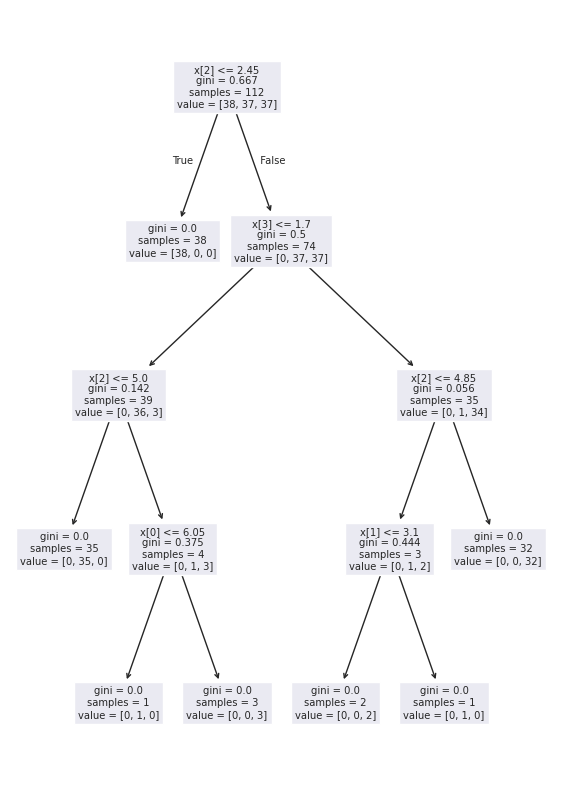

In [17]:
_, ax = plt.subplots(figsize=(7,10))
plot_tree(default_tree['classifier'], ax=ax)

### A tree with higher-than-optimal cpp_alpha

In [13]:
ccp_tree = build_pipeline(ccp_alpha=0.75)
ccp_tree.fit(x_iris, y_iris)

Pipeline(steps=[('dropper', HighNaNDropper(threshold=0.3)),
                ('imputer', KNNImputer()),
                ('classifier', DecisionTreeClassifier(ccp_alpha=0.75))])

[Text(0.5, 0.5, 'gini = 0.667\nsamples = 112\nvalue = [37, 38, 37]')]

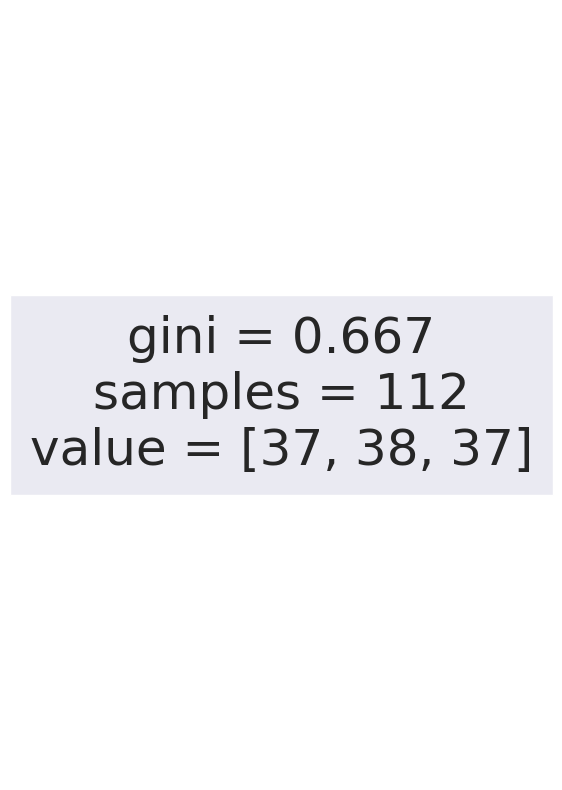

In [14]:
_, ax = plt.subplots(figsize=(7,10))
plot_tree(ccp_tree['classifier'], ax=ax)

### A tree with larger-than-optimal min_samples_leaf

[Text(0.5, 0.9, 'x[3] <= 0.8\ngini = 0.667\nsamples = 112\nvalue = [37, 38, 37]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.41666666666666663, 0.8, 'True  '),
 Text(0.6666666666666666, 0.7, 'x[3] <= 1.75\ngini = 0.5\nsamples = 75\nvalue = [0, 38, 37]'),
 Text(0.5833333333333333, 0.8, '  False'),
 Text(0.5, 0.5, 'x[2] <= 4.85\ngini = 0.172\nsamples = 42\nvalue = [0, 38, 4]'),
 Text(0.3333333333333333, 0.3, 'x[0] <= 5.15\ngini = 0.054\nsamples = 36\nvalue = [0, 35, 1]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.32\nsamples = 5\nvalue = [0, 4, 1]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 31\nvalue = [0, 31, 0]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.5\nsamples = 6\nvalue = [0, 3, 3]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

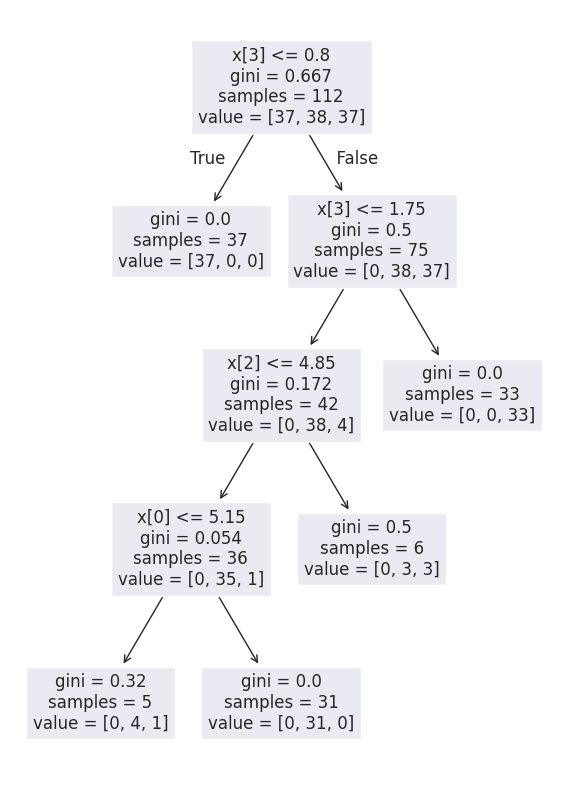

In [15]:
tree_samples_leaf = build_pipeline(min_samples_leaf=5)
tree_samples_leaf.fit(x_iris, y_iris)
_, ax = plt.subplots(figsize=(7,10))
plot_tree(tree_samples_leaf['classifier'], ax=ax)

### A tree with smaller-than-optimal max_depth

[Text(0.4, 0.8333333333333334, 'x[2] <= 2.45\ngini = 0.667\nsamples = 112\nvalue = [37, 38, 37]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[3] <= 1.75\ngini = 0.5\nsamples = 75\nvalue = [0, 38, 37]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.172\nsamples = 42\nvalue = [0, 38, 4]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

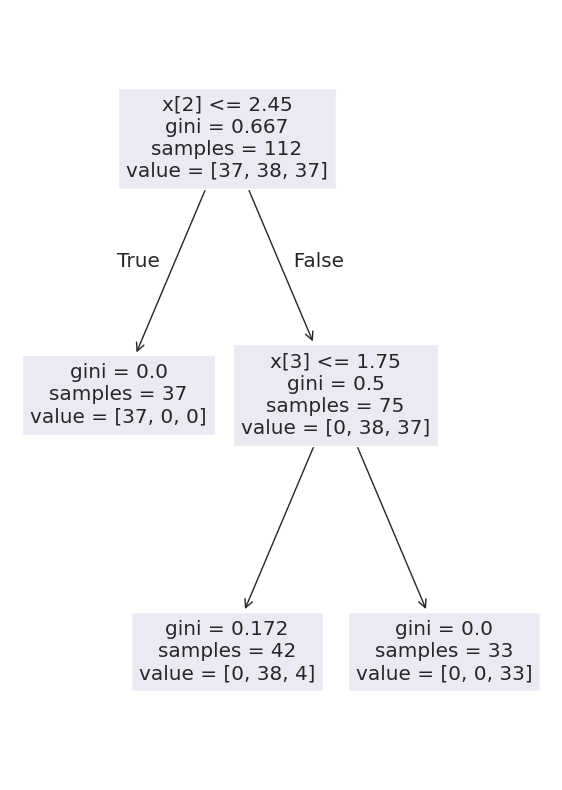

In [16]:
max_depth_tree = build_pipeline(max_depth=2)
max_depth_tree.fit(x_iris, y_iris)
_, ax = plt.subplots(figsize=(7,10))
plot_tree(max_depth_tree['classifier'], ax=ax)

# Cross-validation stratification effect

## Unweighted iris pipeline with good hyperparams

/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


<Axes: >

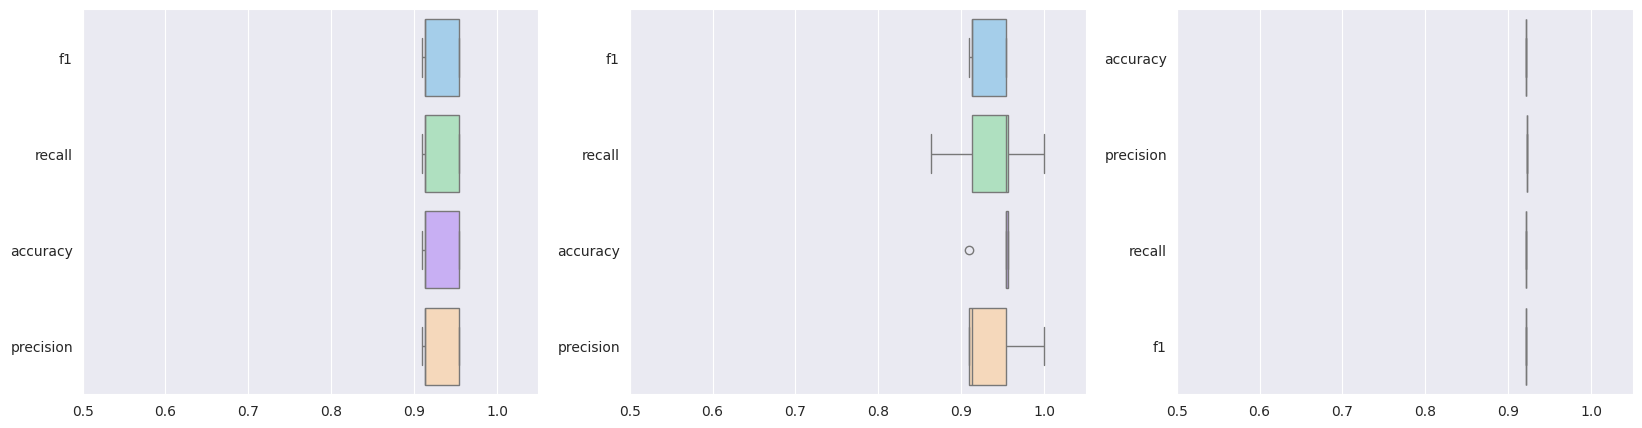

In [28]:
iris_pipeline_unweighted = build_for_hyperparams(hyperparams_iris_unweighted, False)
iris_metrics_unweighted = get_cv_metrics(iris_pipeline_unweighted, x_iris, y_iris, False)
iris_metrics_unweighted_stratified = get_cv_metrics(iris_pipeline_unweighted, x_iris, y_iris, True)
iris_pipeline_unweighted.fit(x_iris, y_iris)
iris_metrics_test_unweighted = get_metrics(iris_pipeline_unweighted, x_iris_test, y_iris_test)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
ax3.set_xlim(0.5, 1.05)
sns.boxplot(data=iris_metrics_unweighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=iris_metrics_unweighted_stratified, palette=colors, orient='h', ax=ax2)
sns.boxplot(data=iris_metrics_test_unweighted, palette=colors, orient='h', ax=ax3)

## Weighted iris pipeline with good hyperparams

/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


<Axes: >

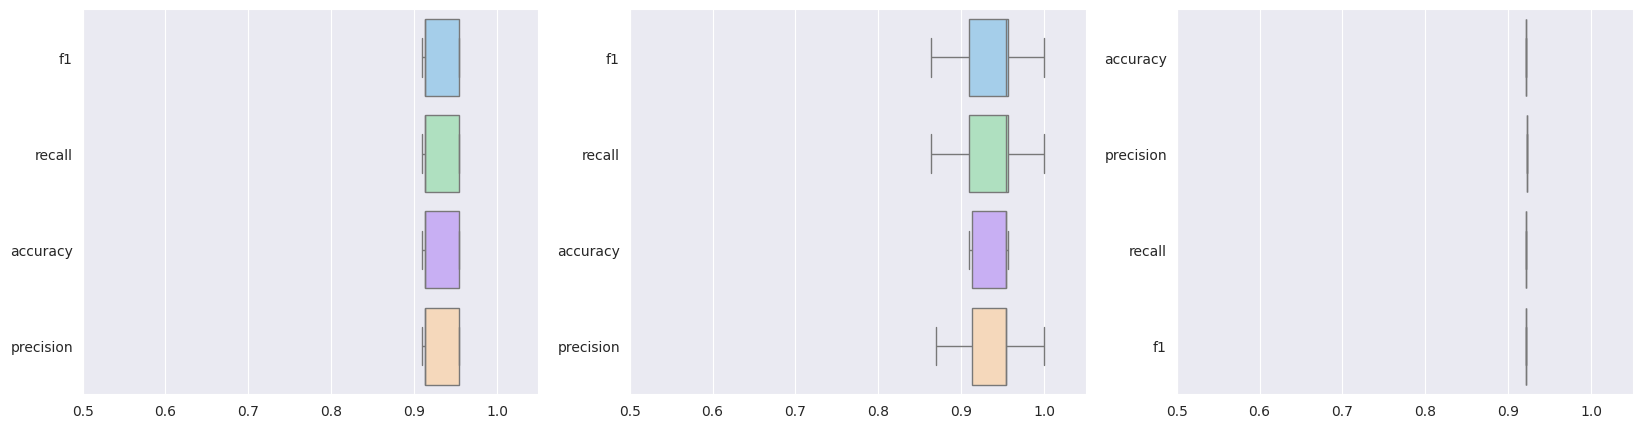

In [29]:
iris_pipeline_weighted = build_for_hyperparams(hyperparams_iris_weighted, True)
iris_metrics_weighted = get_cv_metrics(iris_pipeline_weighted, x_iris, y_iris, False)
iris_metrics_weighted_stratified = get_cv_metrics(iris_pipeline_weighted, x_iris, y_iris, True)
iris_pipeline_weighted.fit(x_iris, y_iris)
iris_metrics_weighted_test = get_metrics(iris_pipeline_weighted, x_iris_test, y_iris_test)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
ax3.set_xlim(0.5, 1.05)
sns.boxplot(data=iris_metrics_weighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=iris_metrics_weighted_stratified, palette=colors, orient='h', ax=ax2)
sns.boxplot(data=iris_metrics_weighted_test, palette=colors, orient='h', ax=ax3)

## Unweighted PCB pipeline with default hyperparams

/home/luke/Documents/studyjka/um/um-3/.venv/lib64/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNNImputer was fitted without feature names
  warnings.warn(


<Axes: >

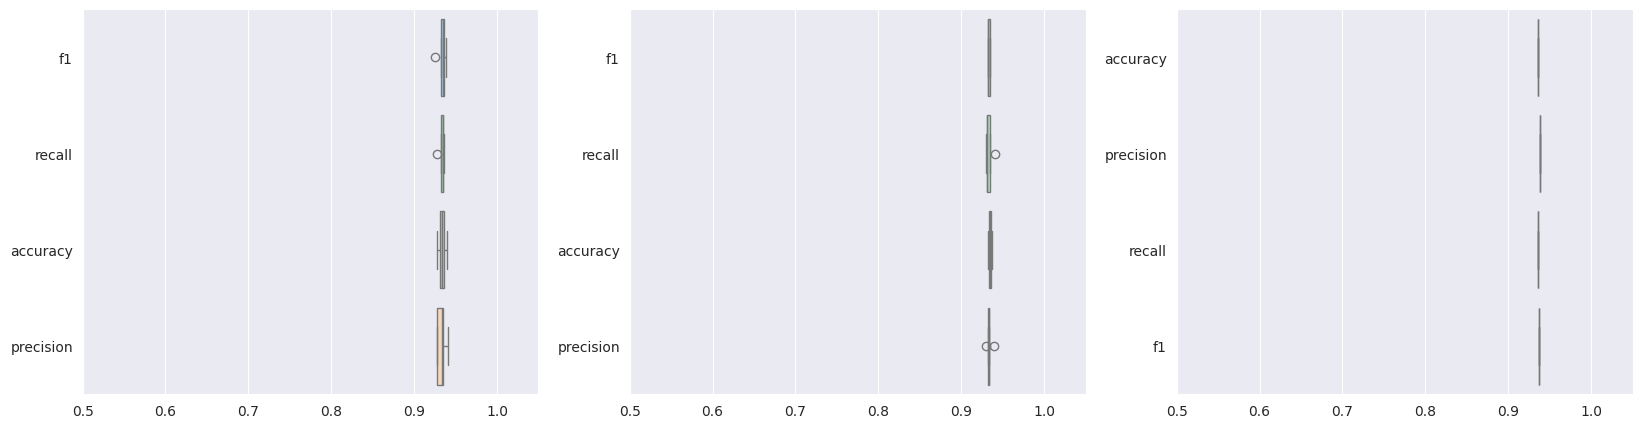

In [33]:
pcb_pipeline_unweighted = build_pipeline()
pcb_metrics_unweighted = get_cv_metrics(pcb_pipeline_unweighted, x_companies, y_companies, False)
pcb_metrics_unweighted_stratified = get_cv_metrics(pcb_pipeline_unweighted, x_companies, y_companies, True)
pcb_pipeline_unweighted.fit(x_companies, y_companies)
pcb_metrics_unweighted_test = get_metrics(pcb_pipeline_unweighted, x_companies_test, y_companies_test)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
ax3.set_xlim(0.5, 1.05)
sns.boxplot(data=pcb_metrics_unweighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=pcb_metrics_unweighted_stratified, palette=colors, orient='h', ax=ax2)
sns.boxplot(data=pcb_metrics_unweighted_test, palette=colors, orient='h', ax=ax3)

## Weighted PCB pipeline with default hyperparams

In [ ]:
pcb_pipeline_weighted = build_pipeline(class_weight='balanced')
pcb_metrics_weighted = get_cv_metrics(pcb_pipeline_weighted, x_companies, y_companies, False)
pcb_metrics_weighted_stratified = get_cv_metrics(pcb_pipeline_weighted, x_companies, y_companies, True)
pcb_pipeline_weighted.fit(x_companies, y_companies)
pcb_metrics_weighted_test = get_metrics(pcb_pipeline_weighted, x_companies_test, y_companies_test)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
ax3.set_xlim(0.5, 1.05)
sns.boxplot(data=pcb_metrics_weighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=pcb_metrics_weighted_stratified, palette=colors, orient='h', ax=ax2)
sns.boxplot(data=pcb_metrics_weighted_test, palette=colors, orient='h', ax=ax3)

# Summary

## Hyperparams - observations

### ccp_alpha

This value controls the strictness of tree pruning. Higher values will cause the pruning algorithm to be more likely to remove nodes that do not cause enough information gain. This mechanism efficiently prevents overfitting but choosing too large of a value may cause the tree to collapse into a single node

### max_depth

This value controls the maximum length of a decision path in a tree. Small values tend to produce a tree where nodes may not cover all cases properly. When applied properly this value prevents the tree from growing too large to the point where it is no longer able to efficiently generalize the rules.

### min_samples_leaf

This parameter control how many samples should be covered by a leaf tree for it not to be absorbed into its' parent node. Choosing a high value may result in high degree of impurity within the leaf nodes. A small value may result in many splits before leaf nodes are reached and may result in overfitting.